# Speaker Recognition

Term project for Machine Learning UoT course

The objective of this Notebook is to predict the speaker of an English digit using a Keras model.

This Notebook has three main sections.
1. Extract the features of the WAV files, save them into CSV files and store them into Pandas
2. The model will be trained based on the data set created by https://github.com/Jakobovski/free-spoken-digit-dataset
3. The model will be re-trained based on the previous data plus the recordings made by Ankor (Indian accent), Caroline (Canadian female child accent) and Rodolfo (Brazilian accent)

## Section 1

The output of this section is the CSV files with the data to be handle by the model

```
trainData     : ../data/recordings/train 
testData      : ../data/recordings/test
```


In [1]:
# If true, the WAV files will be read and their features will be saved in the CSV files
# As this is the most time consuming task, only enable it if you don't have the CSV files yet
CREATE_CSV_FILES = True

In [2]:
# Defines the names of the CSV files
TRAIN_CSV_FILE = "train_dima_tema.csv"
TEST_CSV_FILE = "test_dima_tema.csv"


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import librosa
import csv
import os

def extractWavFeatures(soundFilesFolder, csvFileName):
    print("The features of the files in the folder "+soundFilesFolder+" will be saved to "+csvFileName)
    header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
    for i in range(1, 21):
        header += f' mfcc{i}'
    header += ' label'
    header = header.split()
    print('CSV Header: ', header)
    file = open(csvFileName, 'w', newline='')
    #with file:
    writer = csv.writer(file)
    writer.writerow(header)
    genres = '1 2 3 4 5 6 7 8 9 0'.split()
    for filename in os.listdir(soundFilesFolder):
        number = f'{soundFilesFolder}/{filename}'
        y, sr = librosa.load(number, mono=True, duration=30)
        # remove leading and trailing silence
        y, index = librosa.effects.trim(y)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        writer.writerow(to_append.split())
    file.close()
    print("End of extractWavFeatures")

if (CREATE_CSV_FILES == True):
    extractWavFeatures("../data/recordings/train_dima_tema", TRAIN_CSV_FILE)
    extractWavFeatures("../data/recordings/test_dima_tema", TEST_CSV_FILE)
    print("CSV files are created")
else:
    print("CSV files creation is skipped")

The features of the files in the folder ../data/recordings/train_dima_tema will be saved to train_dima_tema.csv
CSV Header:  ['filename', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'label']
End of extractWavFeatures
The features of the files in the folder ../data/recordings/test_dima_tema will be saved to test_dima_tema.csv
CSV Header:  ['filename', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'label']
End of extractWavFeatures
CSV files are created


In [15]:
#Reading a dataset and convert file name to corresbonding umnber

import pandas as pd
import csv
from sklearn import preprocessing

def preProcessData(csvFileName):
    print(csvFileName+ " will be preprocessed")
    data = pd.read_csv(csvFileName) # shape: 1470(0) x 28(1)
    # we have six speakers: 
    # 0: Jackson
    # 1: Nicolas 
    # 2: Theo
    # 3: Ankur
    # 4: Caroline
    # 5: Rodolfo
    filenameArray = data['filename'] 
    speakerArray = []
    #print(filenameArray)
    for i in range(len(filenameArray)):
        speaker = filenameArray[i][2]
        #print(speaker)
        if speaker == "j":
            speaker = 0
        elif speaker == "n":
            speaker = 1
        elif speaker == "t":
            speaker = 2
        elif speaker == "a":
            speaker = 3
        elif speaker == "c":
            speaker = 4
        elif speaker == "r":
            speaker = 5
        else: 
            speaker = 6
        #print(speaker)
        speakerArray.append(speaker)
    
    data['number'] = speakerArray
    
    #Dropping unnecessary columns
    data = data.drop(['filename'],axis=1)
    data = data.drop(['label'],axis=1)
    data = data.drop(['chroma_stft'],axis=1)
    data.shape

    print("Preprocessing is finished")
    print(data.head())
    return data

trainData = preProcessData(TRAIN_CSV_FILE)
testData = preProcessData(TEST_CSV_FILE)



train_dima_tema.csv will be preprocessed
Preprocessing is finished
       rmse  spectral_centroid  spectral_bandwidth      rolloff  \
0  0.018084        2259.898561         2605.302743  4955.658923   
1  0.019266        1918.007737         2288.109517  4313.254395   
2  0.021764        2578.502273         2747.677795  5452.745361   
3  0.021328        2215.125059         2575.241345  5023.087742   
4  0.014061        2725.053509         2758.626914  5812.469482   

   zero_crossing_rate       mfcc1       mfcc2      mfcc3      mfcc4  \
0            0.083650 -440.503540  104.727837  15.690970   9.861130   
1            0.074072 -458.920410  109.328217   7.701780  14.556528   
2            0.104036 -379.547791   95.150368  20.285648  12.775127   
3            0.078698 -401.235046   99.709312  12.692218  17.790264   
4            0.100484 -434.119995   92.505531  21.977360   3.039394   

       mfcc5  ...    mfcc12     mfcc13     mfcc14     mfcc15    mfcc16  \
0  17.637451  ...  2.969013 -

## Section 2

There are 50 recordings for each digit for each speaker: Jackson, Nicolas and Theo (total 1500 recordings)

Training data has 49 recordings for each digit for each speaker: 1470 recordings total.
Test data has 1 recordings for each digit for each speaker: 30 recordings total.

The data used here comes from the recordings stored in:
* ../data/recordings/train
* ../data/recordings/test

The model will be trained to predict the speker of a digit.

In [16]:
# Splitting the dataset into training, validation and testing dataset
from sklearn.model_selection import train_test_split
X = np.array(trainData.iloc[:, :-1], dtype = float)
y = trainData.iloc[:, -1]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

X_test = np.array(testData.iloc[:, :-1], dtype = float)
y_test = testData.iloc[:, -1]

print("Y from training data:", y_train.shape)
print("Y from validation data:", y_val.shape)
print("Y from test data:", y_test.shape)


Y from training data: (1029,)
Y from validation data: (441,)
Y from test data: (30,)


In [17]:
#Normalizing the dataset
from sklearn.preprocessing import StandardScaler
import numpy as np
scaler = StandardScaler()
X_train = scaler.fit_transform( X_train )
X_val = scaler.transform( X_val )
X_test = scaler.transform( X_test )

print("X from training data", X_train.shape)
print("X from validation data", X_val.shape)
print("X from test data", X_test.shape)


X from training data (1029, 25)
X from validation data (441, 25)
X from test data (30, 25)


In [18]:
#Creating a Model
from keras import models
from keras import layers
import keras

# model 1
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

# Learning Process of a model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# simple early stopping
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

#X_train = np.delete(X_train, len(X_train) - 1, axis = 1)
#print(X_train)
model.summary()
#Train with early stopping to avoid overfitting
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=128)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               6656      
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 10)               

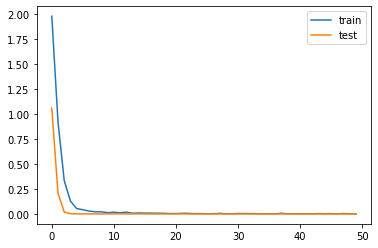

In [19]:
# plot training history
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### Auxiliary functions to show the results


In [20]:
def getSpeaker(speaker):
    #speaker = str(speaker)
    if speaker == 0:
        return "Jackson"
    elif speaker == 1:
        return "Nicola"
    elif speaker == 2:
        return "Theo"
    elif speaker == 3:
        return "Ankur"
    elif speaker == 4:
        return "Caroline"
    elif speaker == 5:
        return "Rodolfo"
    else: 
        speaker = "Unknown"
        
def printPrediction(X_data, y_data, printDigit):
    print('\n# Generate predictions')
    for i in range(len(y_data)):
        prediction = getSpeaker(np.argmax(model.predict(X_data[i:i+1]), axis=-1)[0])
        #deprecetad:  prediction = getSpeaker(model.predict_classes(X_data[i:i+1])[0])

        speaker = getSpeaker(y_data[i])
        if printDigit == True:
            print("Number={0:d}, y={1:10s}- prediction={2:10s}- match={3}".format(i, speaker, prediction, speaker==prediction))
        else:
            print("y={0:10s}- prediction={1:10s}- match={2}".format(speaker, prediction, speaker==prediction))

In [21]:
import numpy as np
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

def report(X_data, y_data):
    #Confution Matrix and Classification Report
    Y_pred = model.predict_classes(X_data)
    y_test_num = y_data.astype(np.int64)
    conf_mt = confusion_matrix(y_test_num, Y_pred)
    print(conf_mt)
    plt.matshow(conf_mt)
    plt.show()
    print('\nClassification Report')
    target_names = ["Jackson", "Nicola", "Theo", "Ankur", "Caroline", "Rodolfo", "Unknown"]
    print(classification_report(y_test_num, Y_pred))


### Present the model performance

In [22]:
print('\n# TEST DATA #\n')
score = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

# Prediction
printPrediction(X_test[0:10], y_test[0:10], False)


# TEST DATA #

1/1 [==============================] - 0s 64ms/step - loss: 0.0000e+00 - accuracy: 1.0000
accuracy: 100.00%

# Generate predictions
1/1 [==============================] - 0s 200ms/step
y=Jackson   - prediction=Jackson   - match=True
1/1 [==============================] - 0s 48ms/step
y=Nicola    - prediction=Nicola    - match=True
1/1 [==============================] - 0s 69ms/step
y=Theo      - prediction=Theo      - match=True
1/1 [==============================] - 0s 65ms/step
y=Jackson   - prediction=Jackson   - match=True
1/1 [==============================] - 0s 56ms/step
y=Nicola    - prediction=Nicola    - match=True
1/1 [==============================] - 0s 65ms/step
y=Theo      - prediction=Theo      - match=True
1/1 [==============================] - 0s 48ms/step
y=Jackson   - prediction=Jackson   - match=True
1/1 [==============================] - 0s 57ms/step
y=Nicola    - prediction=Nicola    - match=True
1/1 [==============================] - 0s 49ms/step

In [ ]:
print("Classification Report for Test Data\n")
report(X_test, y_test)


## Section 3

There are 50 recordings for each digit for each speaker: Jackson, Nicolas and Theo (total 1500 recordings)
Training data has 49 recordings for each digit for each speaker: 1470 recordings total.
Test data has 1 recordings for each digit for each speaker: 30 recordings total.

In addition, there are 2 recordings for each digit for each speaker: Ankur, Caroline and Rodolfo (total 60 recordings)
This addition training data has 1 recordings for each digit for each speaker: 30 recordings total.
This addition test data has 1 recordings for each digit for each speaker: 30 recordings total.

Therefore the full data set has:
* Training: 1500 recordings
* Training: 60 recordings

The data used here comes from the recordings stored in:
* ../data/recordings/train
* ../data/recordings/test
* ../data/recordings/moreSpeakersTrain
* ../data/recordings/moreSpeakersTest

In [ ]:
# Splitting the dataset into training, validation and testing dataset
from sklearn.model_selection import train_test_split

fullTrainData = trainData.append(moreTrainData)

X = np.array(fullTrainData.iloc[:, :-1], dtype = float)
y = fullTrainData.iloc[:, -1]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

X_test = np.array(testData.iloc[:, :-1], dtype = float)
y_test = testData.iloc[:, -1]

X_more_test = np.array(moreTestData.iloc[:, :-1], dtype = float)
y_more_test = moreTestData.iloc[:, -1]

print("Y from training data:", y_train.shape)
print("Y from validation data:", y_val.shape)
print("Y from test data:", y_test.shape)
print("Y from other speakers test data:", y_more_test.shape)


In [ ]:
#Normalizing the dataset
from sklearn.preprocessing import StandardScaler
import numpy as np
scaler = StandardScaler()
X_train = scaler.fit_transform( X_train )
X_val = scaler.transform( X_val )
X_test = scaler.transform( X_test )
X_more_test = scaler.transform( X_more_test )

print("X from training data", X_train.shape)
print("X from validation data", X_val.shape)
print("X from test data", X_test.shape)
print("X from other speakers test data", X_more_test.shape)


In [ ]:
#Creating a Model
from keras import models
from keras import layers
import keras

# model 1
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

# Learning Process of a model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# simple early stopping
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

#Train with early stopping to avoid overfitting
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=128, 
                    callbacks=[es])

In [ ]:
# plot training history
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### Present the model performance

In [ ]:
print('\n# TEST DATA #\n')
score = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

# Prediction
printPrediction(X_test[0:10], y_test[0:10], False)

In [ ]:
print('\n# OTHER SPEAKERS DATA #\n')
score = model.evaluate(X_more_test, y_more_test)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

# Prediction
printPrediction(X_more_test[0:10], y_more_test[0:10], False)


In [ ]:
print("Classification Report for Test Data\n")
report(X_test, y_test)

print("Classification Report for Other Speakers\n")
report(X_more_test, y_more_test)
